# What does an customer default with Afterpay look like ?
> Let's take a high level view of what an aveage default looks like, based on Afterpay's FY2019 Annual report.

- toc: true 
- badges: true
- comments: true
- categories: [Bayesian,PyMC3,Finance,Monte Carlo Simulation,Afterpay]
    
- image: images/2020-08-22-Afterpay-Customer-Defaults-Part-3/header.png

# POST IN PROGRESS

## Introduction

From the [previous post]()


> Important:  Obviously I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.




## Robustness Study

We now have ability to compute the expected average late fee, given a distribution of transaction values, and a probability of making payment on time.

Given this, we can try lots of different distributions, and use this to find the distribution of average late fees that we could see.




In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

## Improving performance

### Direct Model

This model takes 3 seconds to generate 100,000 samples.

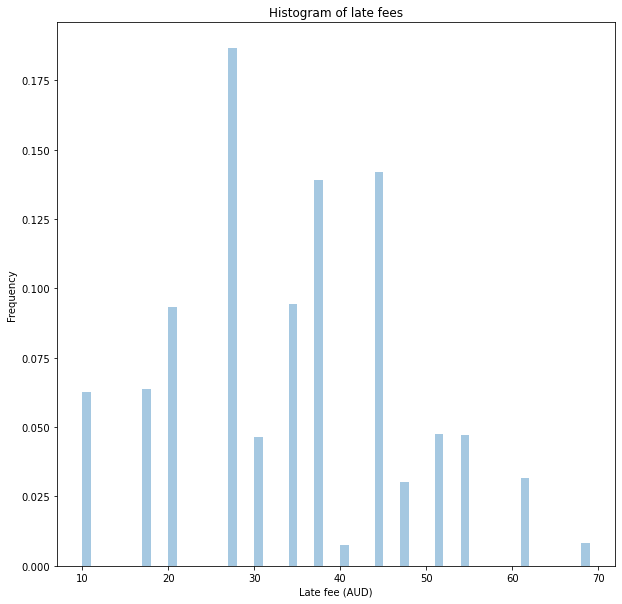

In [2]:
def create_late_fee_distribution(late_payment_probability, num_samples=100_000):
    with pm.Model() as fee_model:
        number_of_delays_of_less_than_1_week = 1 + pm.Binomial('number_of_delays_of_less_than_1_week', n=3, p=late_payment_probability)
        number_of_delays_of_more_than_1_week = pm.Binomial('number_of_delays_of_more_than_1_week', n=number_of_delays_of_less_than_1_week, p=late_payment_probability)
        total_fees = pm.Deterministic('total_fees',10 * number_of_delays_of_less_than_1_week + 7 * number_of_delays_of_more_than_1_week)

        samples = pm.sample_prior_predictive(samples = num_samples, random_seed=0)
    return(samples)


samples = create_late_fee_distribution(late_payment_probability=0.5)

sns.distplot(samples["total_fees"],kde=False, norm_hist=True, bins=np.arange(10,70,1))
plt.title('Histogram of late fees')
plt.ylabel('Frequency')
plt.xlabel('Late fee (AUD)')
plt.show()

### Categorical Model

This model takes 60ms to generate 100,000 samples.

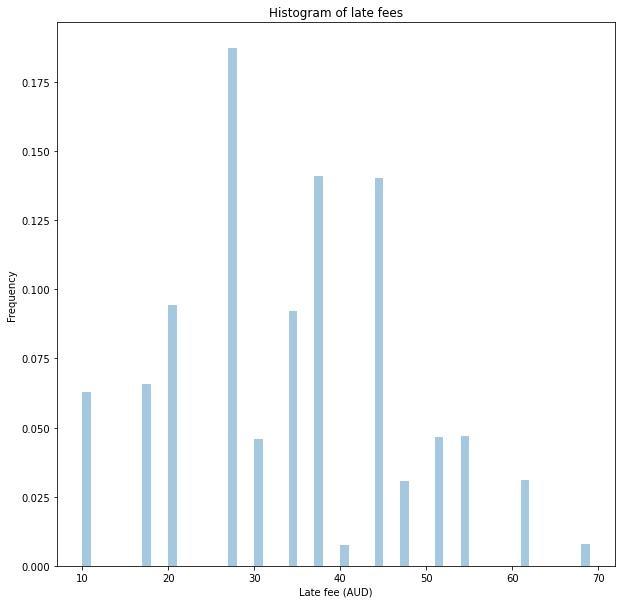

In [3]:
def create_late_fee_surrogate_distribution(late_fee_samples):
    unique, counts = np.unique(late_fee_samples, return_counts=True) 
    
    categorical_map = {}
    for i in range(len(unique)):
        categorical_map[i] = unique[i]
    
    with pm.Model() as categorical_fee_model:
        late_fee_distribution_categorical = pm.Categorical('late_fee_distribution_categorical',counts)
    
    return(categorical_fee_model, categorical_map)

def generate_samples(categorical_fee_model, categorical_map):
    with categorical_fee_model:
        samples = pm.sample_prior_predictive(samples=100_000)

    late_fee_samples = np.zeros_like(samples["late_fee_distribution_categorical"])

    for i in range(len(categorical_map.keys())):
        late_fee_samples[samples["late_fee_distribution_categorical"] == i] = categorical_map[i]

    return(late_fee_samples)

categorical_fee_model, categorical_map = create_late_fee_surrogate_distribution(samples["total_fees"])

late_fee_samples = generate_samples(categorical_fee_model, categorical_map)

plt.title('Histogram of late fees')
plt.ylabel('Frequency')
plt.xlabel('Late fee (AUD)')
sns.distplot(late_fee_samples,kde=False, norm_hist=True, bins=np.arange(10,70,1))
plt.show()

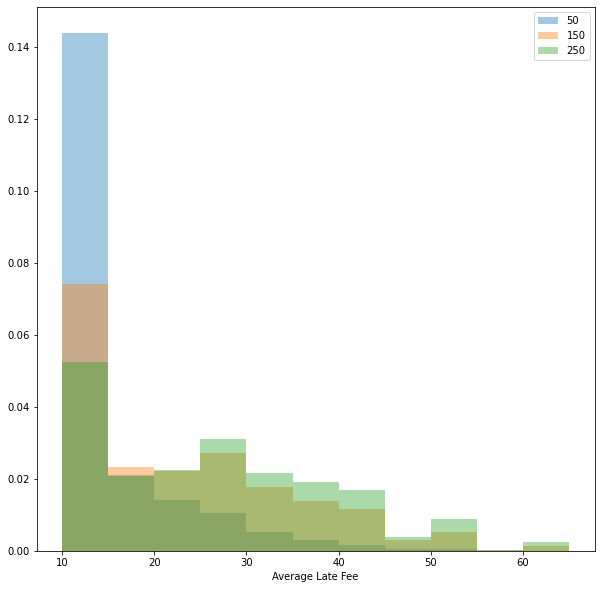

In [4]:
def create_exponential_transaction_value_samples(average_transaction_value_aud):
    with pm.Model() as transaction_value_model:
        transaction_value_aud = pm.Bound(pm.Exponential, upper=1_500.0)('transaction_value_aud', lam = 1/average_transaction_value_aud)
        transaction_value_samples = pm.sample_prior_predictive(samples=100_000)
        transaction_value_samples = transaction_value_samples['transaction_value_aud']
    return(transaction_value_samples)    

for average_transaction_value_aud in [50,150,250]:
    
    transaction_value_samples = create_exponential_transaction_value_samples(average_transaction_value_aud)
    
    late_fee_samples = generate_samples(categorical_fee_model, categorical_map)
    
    late_fees = np.minimum(late_fee_samples,0.25*transaction_value_samples)
    late_fees = np.maximum(late_fees,10)
    
    sns.distplot(late_fees,kde=False, norm_hist = True, bins = np.arange(10,70,5),label=str(average_transaction_value_aud));

plt.legend()
plt.xlabel('Average Late Fee')
plt.show()

## Grid Evaluation

In [5]:
fee_models = {}
for late_payment_probability_percent in range(0, 101,5):
    samples = create_late_fee_distribution(late_payment_probability=late_payment_probability_percent/100.0)
    categorical_fee_model = create_late_fee_surrogate_distribution(samples["total_fees"])
    fee_models[late_payment_probability_percent] = categorical_fee_model

In [18]:
grid = np.zeros((21,20))

for average_transaction_value_aud in range(50,250,10):
    
    transaction_value_samples = create_exponential_transaction_value_samples(average_transaction_value_aud)
    
    for late_payment_probability_percent in range(0, 101,5):
        categorical_fee_model, categorical_map = fee_models[late_payment_probability_percent]
        late_fee_samples = generate_samples(categorical_fee_model,categorical_map)

        late_fees = np.minimum(late_fee_samples, 0.25*transaction_value_samples)
        late_fees = np.maximum(late_fees,10)

        mean_late_fee = np.mean(late_fees)

        grid[int(late_payment_probability_percent/5), int((average_transaction_value_aud-50)/10)] = mean_late_fee

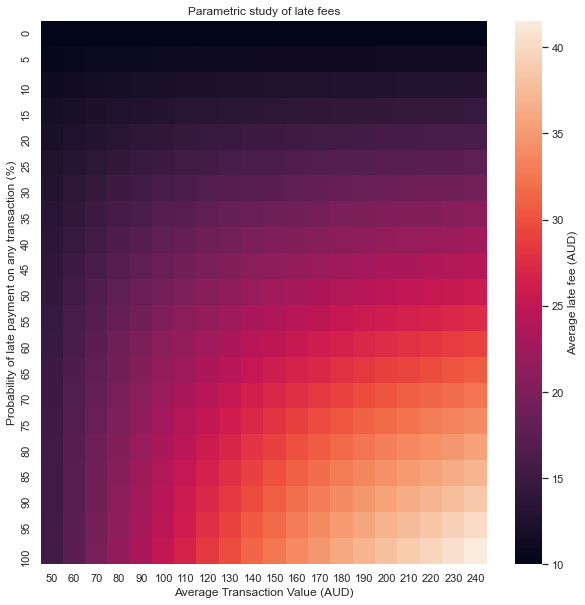

In [29]:
x_axis_labels = range(50,250,10) 
y_axis_labels = range(0, 101,5)

sns.heatmap(grid,xticklabels=x_axis_labels, yticklabels=y_axis_labels,cbar_kws={'label': 'Average late fee (AUD)'})
plt.xlabel('Average Transaction Value (AUD)')
plt.ylabel('Probability of late payment on any transaction (%)')
plt.title('Parametric study of late fees')
plt.show()
